In [1]:
! pip install -r requirements.txt



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


from google.colab import drive
drive.mount('/content/drive')

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Concatenate,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

from numpy import zeros
import os
import pathlib
import time
import datetime
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint

from matplotlib import pyplot as plt
from IPython import display

In [5]:
import tensorflow as tf
import numpy as np
from os import listdir
import os
import re

# Function to extract numerical part from a filename
def extract_number(filename):
    match = re.search(r'\d+', filename)  # Extract digits
    return int(match.group()) if match else -1

# Function to load and align images in a directory
def load_images(path, size=(256, 256)):
    # Paths to input and target directories
    input_list = os.path.join(path, "real")  # Adjust folder names as needed
    target_list = os.path.join(path, "cartoon")

    # Get filenames and sort by extracted number
    input_files = sorted(listdir(input_list), key=extract_number)
    target_files = sorted(listdir(target_list), key=extract_number)

    src_list, tar_list = [], []

    # Ensure both directories have the same number of files
    if len(input_files) != len(target_files):
        raise ValueError("Number of input and target images does not match!")

    # Iterate through sorted filenames
    for input_file, target_file in zip(input_files, target_files):
        # Load and resize input image
        input_path = os.path.join(input_list, input_file)
        input_img = tf.keras.utils.load_img(input_path, target_size=size)
        src_list.append(np.array(input_img))

        # Load and resize target image
        target_path = os.path.join(target_list, target_file)
        target_img = tf.keras.utils.load_img(target_path, target_size=size)
        tar_list.append(np.array(target_img))

    return np.asarray(src_list), np.asarray(tar_list)

# Dataset path
path = 'train/Butler_Jimmy/'

# Load the dataset
src_images, tar_images = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

# Save as compressed numpy array
filename = 'basket_256.npz'
np.savez_compressed(filename, src_images=src_images, tar_images=tar_images)
print('Saved dataset: ', filename)


Loaded:  (87, 256, 256, 3) (87, 256, 256, 3)
Saved dataset:  basket_256.npz


Loaded:  (87, 256, 256, 3) (87, 256, 256, 3)


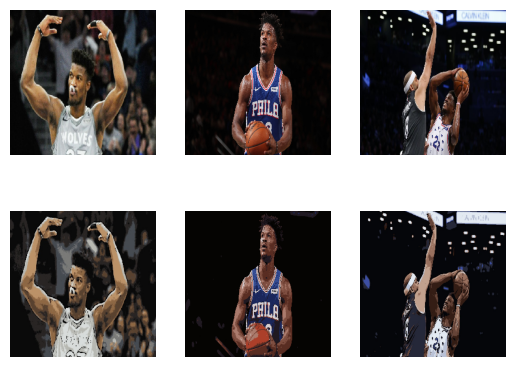

In [6]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('basket_256.npz')
# Access the arrays using the correct keys: 'src_images' and 'tar_images'
src_images, tar_images = data['src_images'], data['tar_images']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Conv2D, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(image_shape):
    """
    Define a PatchGAN discriminator model in TensorFlow.

    Args:
        image_shape (tuple): Shape of the input images (height, width, channels).

    Returns:
        tf.keras.Model: Compiled discriminator model.
    """
    # Weight initialization
    init = RandomNormal(stddev=0.02)

    # Source image input
    in_src_image = Input(shape=image_shape, name='source_image')
    # Target image input
    in_target_image = Input(shape=image_shape, name='target_image')

    # Concatenate images channel-wise
    merged = Concatenate(name='concatenate_images')([in_src_image, in_target_image])

    # C64: First convolutional layer
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, name='conv1')(merged)
    d = LeakyReLU(alpha=0.2, name='lrelu1')(d)

    # C128: Second convolutional layer
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, name='conv2')(d)
    d = BatchNormalization(name='batchnorm2')(d)
    d = LeakyReLU(alpha=0.2, name='lrelu2')(d)

    # C256: Third convolutional layer
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, name='conv3')(d)
    d = BatchNormalization(name='batchnorm3')(d)
    d = LeakyReLU(alpha=0.2, name='lrelu3')(d)

    # C512: Fourth convolutional layer
    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, name='conv4')(d)
    d = BatchNormalization(name='batchnorm4')(d)
    d = LeakyReLU(alpha=0.2, name='lrelu4')(d)

    # Second-to-last output layer
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init, name='conv5')(d)
    d = BatchNormalization(name='batchnorm5')(d)
    d = LeakyReLU(alpha=0.2, name='lrelu5')(d)

    # Final output layer: PatchGAN output
    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, name='conv6')(d)
    patch_out = Activation('sigmoid', name='sigmoid_output')(d)

    # Define model
    model = Model([in_src_image, in_target_image], patch_out, name='PatchGAN_Discriminator')

    # Compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

    return model

In [22]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
# ____________________________________________________________________________________________________________________

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
# ____________________________________________________________________________________________________________________

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [23]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt)
	# , loss_weights=[1,100]
	return model

In [24]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['src_images'], data['tar_images']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [25]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [26]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [27]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [28]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=2, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, *_ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [29]:

# load image data
dataset = load_real_samples('basket_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset,n_epochs=10)

Loaded (87, 256, 256, 3) (87, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [ ]:
# example of loading a pix2pix model and using it for one-off image translation

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot

# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

# load source image
src_image = load_image('maps/maps/train/2.jpg')
print('Loaded', src_image.shape)
pyplot.subplot(2, 1, 1)
pyplot.imshow(src_image[0].astype('uint8'))
# load model
model = load_model('model_002193.h5',compile=True)

# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.subplot(2, 1, 2)
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Instantiate the generator and discriminator models
generator = define_generator()  # Create an instance of the generator
discriminator = define_discriminator(image_shape)  # Create an instance of the discriminator

# Now create the checkpoint with the model instances
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,  # Pass the generator instance
                                 discriminator=discriminator)  # Pass the discriminator instance

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
# Split into train and test sets
input_train, input_test, target_train, target_test = train_test_split(
    src_images, tar_images , test_size=0.2, random_state=42
)
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
# summarize_performance(2192, g_model, dataset)